In [ ]:
import numpy as np
import scipy as spy
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {}
import seaborn as sns
import pandas as pd
from pyswmm_lite import Env
import pickle
from automate_objective import generate_targets, generate_weights
from utilities_baeopt import swmm_execute, uncontrolled_response
import matplotlib.pyplot as plt
from GPyOpt.methods import BayesianOptimization
import requests
np.random.seed(42)
NODES_LIS = {'93-49743' : 'OR39',
             '93-49868' : 'OR34',
             '93-49919' : 'OR44',
             '93-49921' : 'OR45',
             '93-50074' : 'OR38',
             '93-50076' : 'OR46',
             '93-50077' : 'OR48',
             '93-50081' : 'OR47',
             '93-50225' : 'OR36',
             '93-90357' : 'OR43',
             '93-90358' : 'OR35'}

def performance_metric(data, ctrl_weights, threshold=5.0, verbose=False):
    """
    Computes performance metrics for the optimization 
    based on the threshold. 

    Parameters:
    --------------------------------------------------
    data: dict of pandas dataframes with outflows and flooding

    Returns:
    --------------------------------------------------
    performance_metric : pefromance of the objetive 
    """
    outflows = data["outflows"]
    flooding = data["flooding"]
    # Get the performance metric 
    perforamce  = 0.0
    # Check if there is flooding in the assets 
    flooding = flooding.gt(0.0)
    flooding = flooding.any()
    if flooding.any(): 
        if verbose:
            # TODO print the quantity of flooding
            print("Nodes with flooding: {}".format(flooding[flooding == True].index))
        perforamce += 10**8
    # Estimate the perfomance from the flows
    outflows = outflows.sub(threshold)
    outflows[outflows < 0.0] = 0.0
    outflows = outflows.sum()
    for i in outflows.keys():
        perforamce += outflows[i] * ctrl_weights[i]
    return perforamce

# Set up the objective function
data_uncontrolled = np.load("./uncontrolled_flow_AA.npy").item()
inflows_uncontrolled = data_uncontrolled["inflows"]
# Control weights 
ctrl_weights = generate_weights(inflows_uncontrolled)

# Set the threshold
THRESHOLD = 5.0 
ctrl_elements = ['93-50077']
number_of_ctrl_elements = 1 
save_path = "./uncertain_single/"
def objective_function(x):
    # Run SWMM and get the trajectories 
    # Pick a random snapshot 
    i = np.random.choice(np.linspace(1, 20, 20, dtype=int), 1)
    data = swmm_execute(x, ctrl_elements, network="./raindata/"+str(i[0])+"runfile.inp")
    obj_value = performance_metric(data, ctrl_weights, THRESHOLD)
    return obj_value

# Create the domain
domain = []
for i in range(1, number_of_ctrl_elements+1):
    domain.append({'name': 'var_'+str(i), 'type': 'continuous', 'domain': (0.0, 1.0)})

# Solve the bayesian optimization 
myBopt = BayesianOptimization(f=objective_function, domain=domain, model_type = 'GP', acquisition_type='EI')

In [63]:
f_open = open("./uncertain_single/Bayopt350", 'rb')
myBopt.__dict__.update(pickle.load(f_open))
myBopt._compute_results()

In [64]:
# Plot the convergence based on gpyopt 
def plot_acquisition(axis, model):
    bounds = model.acquisition.space.get_bounds()

    x_grid = np.arange(bounds[0][0], bounds[0][1], 0.001)
    x_grid = x_grid.reshape(len(x_grid),1)
    acqu = model.acquisition.acquisition_function(x_grid)
    acqu_normalized = (-acqu - min(-acqu))/(max(-acqu - min(-acqu)))
    m, v = model.model.predict(x_grid)

    axis.plot(x_grid, m, 'k-',lw=1,color="#183661", linewidth=1.0)
    axis.fill_between(x_grid.reshape(-1), (m-1.96*np.sqrt(v)).reshape(-1), (m+1.96*np.sqrt(v)).reshape(-1), color="#3a9679", alpha = 0.4)

    factor = max(m+1.96*np.sqrt(v))-min(m-1.96*np.sqrt(v))
    axis.plot(x_grid, 0.2*factor*acqu_normalized-abs(min(m-1.96*np.sqrt(v)))-0.25*factor,
            'r-',lw=2)

    axis.set_xlabel('Valve Setting')
    axis.set_ylabel('Objective')
    axis.set_ylim(min(m-1.96*np.sqrt(v))-0.25*factor,  max(m+1.96*np.sqrt(v))+0.05*factor)

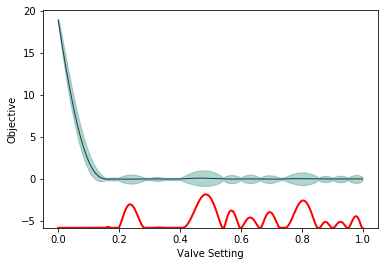

In [65]:
ax1 = plt.subplot2grid((1, 1), (0, 0))
plot_acquisition(ax1, myBopt)
sns.deps